In [60]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from math import sqrt
import plotly.graph_objects as go
import statsmodels.api as sm
import math
import plotly.express as px
import random
import re

In [61]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [62]:
df_netflix= pd.read_csv('/content/drive/MyDrive/netflix_titles.csv', usecols=['show_id','title','director','cast','listed_in','description'])
df_titles= pd.read_csv('/content/drive/MyDrive/titles.csv', usecols=['id','title','type','genres','imdb_votes','imdb_score','tmdb_popularity','tmdb_score'])
df_credits= pd.read_csv('/content/drive/MyDrive/credits.csv')
df_imdb= pd.read_csv('/content/drive/MyDrive/imdb_top_1000.csv', usecols=['Series_Title', 'Gross'])

In [63]:
df_netflix['title'] = df_netflix['title'].str.lower().str.strip()
df_titles['title'] = df_titles['title'].str.lower().str.strip()
df_imdb['Series_Title']= df_imdb['Series_Title'].str.lower().str.strip()
df_imdb['Gross']= df_imdb['Gross'].str.lower().str.strip()

In [64]:
def clean_title(text):
    if isinstance(text, str):
        return re.sub(r'[^a-zA-Z0-9\s]', '', text)
    else:
        return text

df_netflix['title'] = df_netflix['title'].apply(clean_title)
df_titles['title'] = df_titles['title'].apply(clean_title)
df_imdb['Series_Title'] = df_imdb['Series_Title'].apply(clean_title)


In [65]:
def remove_suffix(title):
    if isinstance(title, str):  # Checking if the input is a string
        if title.endswith('the movie'):
            return title[:-9].strip()
    return title

# Applying the remove_suffix function to the 'title' column of each DataFrame
df_netflix['title'] = df_netflix['title'].apply(remove_suffix)
df_titles['title'] = df_titles['title'].apply(remove_suffix)
df_imdb['Series_Title'] = df_imdb['Series_Title'].apply(remove_suffix)


In [66]:
merged_df = pd.merge(df_titles, df_credits, on='id', how='inner')
remerged_df = pd.merge(merged_df, df_netflix, on='title', how='inner')
reremerged_df = pd.merge(remerged_df, df_imdb[['Series_Title', 'Gross']], left_on='title', right_on='Series_Title', how='inner')

In [67]:
print(reremerged_df[['title', 'Series_Title']].sample(5))

                            title                 Series_Title
271   once upon a time in america  once upon a time in america
1760                  udta punjab                  udta punjab
148                    goodfellas                   goodfellas
1716          beasts of no nation          beasts of no nation
669                     inception                    inception


In [68]:
mismatches = reremerged_df[reremerged_df['title'] != reremerged_df['Series_Title']]
print(f"Number of mismatches: {len(mismatches)}")

if len(mismatches) > 0:
    print("Here are some mismatches:")
    print(mismatches[['title', 'Series_Title']].head())

Number of mismatches: 0


In [69]:
reremerged_df.drop('Series_Title', axis=1, inplace=True)

In [70]:
reremerged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2479 entries, 0 to 2478
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               2479 non-null   object 
 1   title            2479 non-null   object 
 2   type             2479 non-null   object 
 3   genres           2479 non-null   object 
 4   imdb_score       2384 non-null   float64
 5   imdb_votes       2384 non-null   float64
 6   tmdb_popularity  2479 non-null   float64
 7   tmdb_score       2479 non-null   float64
 8   person_id        2479 non-null   int64  
 9   name             2479 non-null   object 
 10  character        2368 non-null   object 
 11  role             2479 non-null   object 
 12  show_id          2479 non-null   object 
 13  director         2443 non-null   object 
 14  cast             2479 non-null   object 
 15  listed_in        2479 non-null   object 
 16  description      2479 non-null   object 
 17  Gross         

In [71]:
reremerged_df.describe()

,imdb_score,imdb_votes,tmdb_popularity,tmdb_score,person_id
count,2384.000000,2.384000e+03,2479.000000,2479.000000,2.479000e+03
mean,7.785738,4.760895e+05,31.094015,7.583423,3.849510e+05
std,0.797056,4.926980e+05,23.570397,0.670965,5.460216e+05
min,3.100000,3.200000e+01,0.849000,3.700000,2.190000e+02
25%,7.700000,9.964700e+04,15.070000,7.400000,1.387500e+04
50%,7.900000,3.038680e+05,22.225000,7.600000,8.072400e+04
75%,8.200000,6.496760e+05,42.131000,8.000000,6.600315e+05
max,8.800000,2.294231e+06,134.700000,8.463000,2.435238e+06


In [72]:
print(reremerged_df.isnull().sum())

id                   0
title                0
type                 0
genres               0
imdb_score          95
imdb_votes          95
tmdb_popularity      0
tmdb_score           0
person_id            0
name                 0
character          111
role                 0
show_id              0
director            36
cast                 0
listed_in            0
description          0
Gross              287
dtype: int64


In [73]:
reremerged_df.columns = reremerged_df.columns.str.title()

In [74]:
reremerged_df['Imdb_Score'].fillna(reremerged_df['Imdb_Score'].mean(), inplace=True)

reremerged_df['Imdb_Votes'].fillna(reremerged_df['Imdb_Votes'].median(), inplace=True)

reremerged_df['Tmdb_Score'].fillna(reremerged_df['Tmdb_Score'].mean(), inplace=True)

reremerged_df['Director'].fillna('Unknown', inplace=True)

reremerged_df['Character'].fillna('Unknown', inplace=True)

most_common_cast = reremerged_df['Cast'].mode()[0]
reremerged_df['Cast'].fillna(most_common_cast, inplace=True)

# Removing commas
reremerged_df['Gross'] = reremerged_df['Gross'].replace(',', '', regex=True)

# Conversion process
reremerged_df['Gross'] = reremerged_df['Gross'].astype(float)

# Comma separated values can now be treated as decimals when calculating median
gross_median = reremerged_df['Gross'].median()
reremerged_df['Gross'].fillna(gross_median, inplace=True)

In [75]:
print(reremerged_df.isnull().sum())

Id                 0
Title              0
Type               0
Genres             0
Imdb_Score         0
Imdb_Votes         0
Tmdb_Popularity    0
Tmdb_Score         0
Person_Id          0
Name               0
Character          0
Role               0
Show_Id            0
Director           0
Cast               0
Listed_In          0
Description        0
Gross              0
dtype: int64


In [76]:
duplicate_rows = reremerged_df.duplicated().sum()

print("Number of duplicate rows:", duplicate_rows)

Number of duplicate rows: 0


In [77]:
reremerged_df

,Id,Title,Type,Genres,Imdb_Score,Imdb_Votes,Tmdb_Popularity,Tmdb_Score,Person_Id,Name,Character,Role,Show_Id,Director,Cast,Listed_In,Description,Gross
0,tm84618,taxi driver,MOVIE,"['drama', 'crime']",8.2,808582.0,40.965,8.179,3748,Robert De Niro,Travis Bickle,ACTOR,s2882,Daniel Oriahi,"Odunlade Adekola, Ijeoma Grace Agu, Richard Ak...","Comedies, Dramas, Independent Movies","After his father dies, a young mechanic moves ...",28262574.0
1,tm84618,taxi driver,MOVIE,"['drama', 'crime']",8.2,808582.0,40.965,8.179,14658,Jodie Foster,Iris Steensma,ACTOR,s2882,Daniel Oriahi,"Odunlade Adekola, Ijeoma Grace Agu, Richard Ak...","Comedies, Dramas, Independent Movies","After his father dies, a young mechanic moves ...",28262574.0
2,tm84618,taxi driver,MOVIE,"['drama', 'crime']",8.2,808582.0,40.965,8.179,7064,Albert Brooks,Tom,ACTOR,s2882,Daniel Oriahi,"Odunlade Adekola, Ijeoma Grace Agu, Richard Ak...","Comedies, Dramas, Independent Movies","After his father dies, a young mechanic moves ...",28262574.0
3,tm84618,taxi driver,MOVIE,"['drama', 'crime']",8.2,808582.0,40.965,8.179,3739,Harvey Keitel,Matthew 'Sport' Higgins,ACTOR,s2882,Daniel Oriahi,"Odunlade Adekola, Ijeoma Grace Agu, Richard Ak...","Comedies, Dramas, Independent Movies","After his father dies, a young mechanic moves ...",28262574.0
4,tm84618,taxi driver,MOVIE,"['drama', 'crime']",8.2,808582.0,40.965,8.179,48933,Cybill Shepherd,Betsy,ACTOR,s2882,Daniel Oriahi,"Odunlade Adekola, Ijeoma Grace Agu, Richard Ak...","Comedies, Dramas, Independent Movies","After his father dies, a young mechanic moves ...",28262574.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2474,ts288540,ray,SHOW,"['drama', 'thriller', 'crime']",7.1,8795.0,5.791,6.800,66872,Manoj Bajpayee,Musafir Ali,ACTOR,s638,"Srijit Mukherji, Vasan Bala, Abhishek Chaubey","Manoj Bajpayee, Gajraj Rao, Kay Kay Menon, Ali...","International TV Shows, TV Dramas, TV Mysteries","From a satire to a psychological thriller, fou...",75331600.0
2475,ts288540,ray,SHOW,"['drama', 'thriller', 'crime']",7.1,8795.0,5.791,6.800,67162,Kay Kay Menon,Indrashish Shah,ACTOR,s638,"Srijit Mukherji, Vasan Bala, Abhishek Chaubey","Manoj Bajpayee, Gajraj Rao, Kay Kay Menon, Ali...","International TV Shows, TV Dramas, TV Mysteries","From a satire to a psychological thriller, fou...",75331600.0
2476,ts288540,ray,SHOW,"['drama', 'thriller', 'crime']",7.1,8795.0,5.791,6.800,235529,Harshvardhan Kapoor,Vik,ACTOR,s638,"Srijit Mukherji, Vasan Bala, Abhishek Chaubey","Manoj Bajpayee, Gajraj Rao, Kay Kay Menon, Ali...","International TV Shows, TV Dramas, TV Mysteries","From a satire to a psychological thriller, fou...",75331600.0
2477,ts288540,ray,SHOW,"['drama', 'thriller', 'crime']",7.1,8795.0,5.791,6.800,940893,Radhika Madan,Didi,ACTOR,s638,"Srijit Mukherji, Vasan Bala, Abhishek Chaubey","Manoj Bajpayee, Gajraj Rao, Kay Kay Menon, Ali...","International TV Shows, TV Dramas, TV Mysteries","From a satire to a psychological thriller, fou...",75331600.0


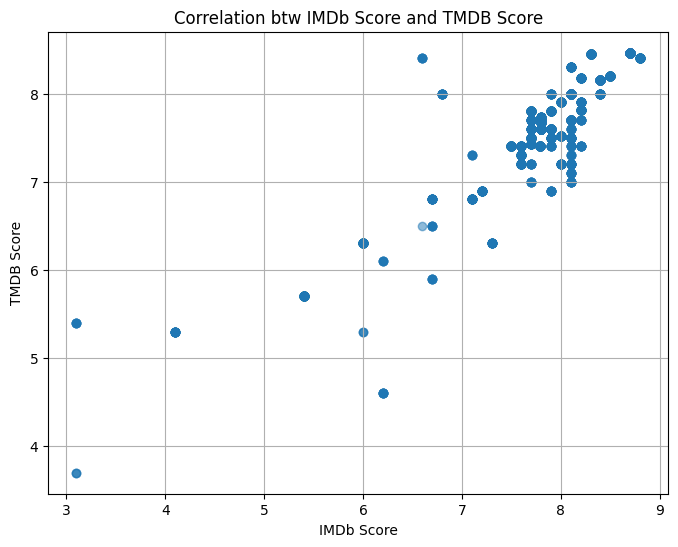

In [78]:
plt.figure(figsize=(8, 6))
plt.scatter(reremerged_df['Imdb_Score'], reremerged_df['Tmdb_Score'], alpha=0.5)
plt.title('Correlation btw IMDb Score and TMDB Score')
plt.xlabel('IMDb Score')
plt.ylabel('TMDB Score')
plt.grid(True)
plt.show()

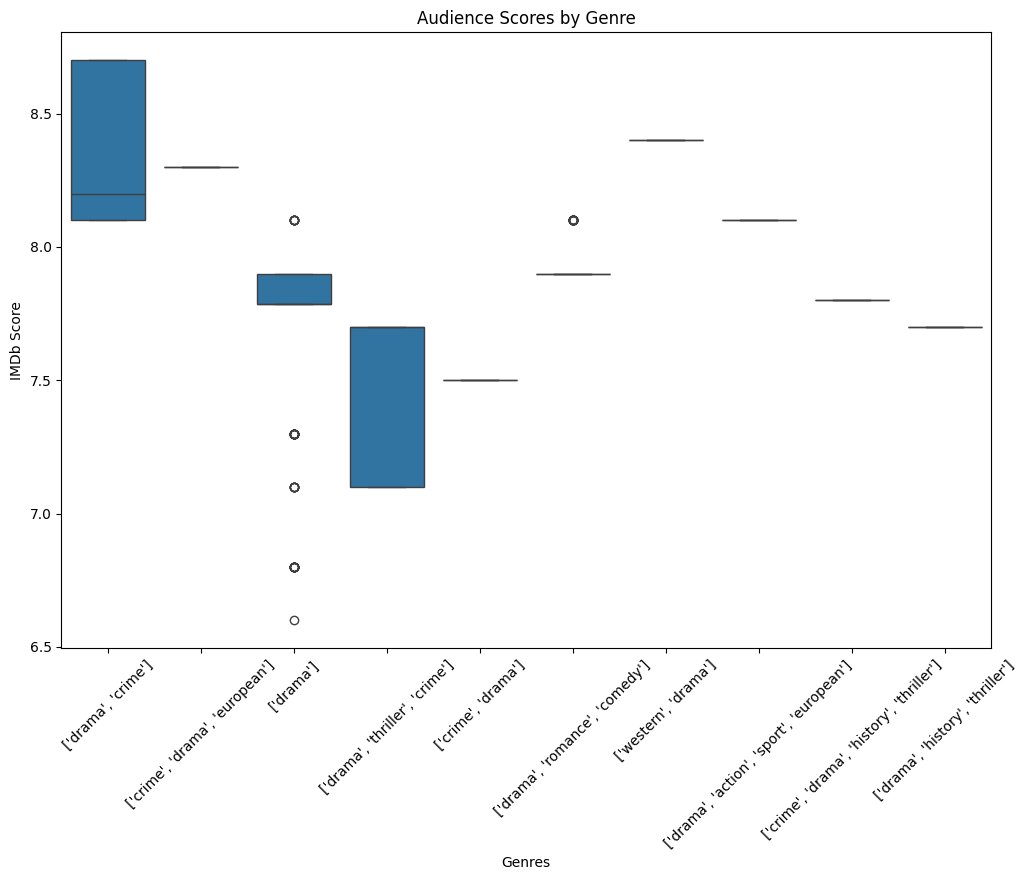

In [79]:
top_genres = reremerged_df['Genres'].value_counts().head(10).index

filtered_df = reremerged_df[reremerged_df['Genres'].isin(top_genres)]

plt.figure(figsize=(12, 8))
sns.boxplot(x='Genres', y='Imdb_Score', data=filtered_df)
plt.title('Audience Scores by Genre')
plt.xlabel('Genres')
plt.ylabel('IMDb Score')
plt.xticks(rotation=45)
plt.show()

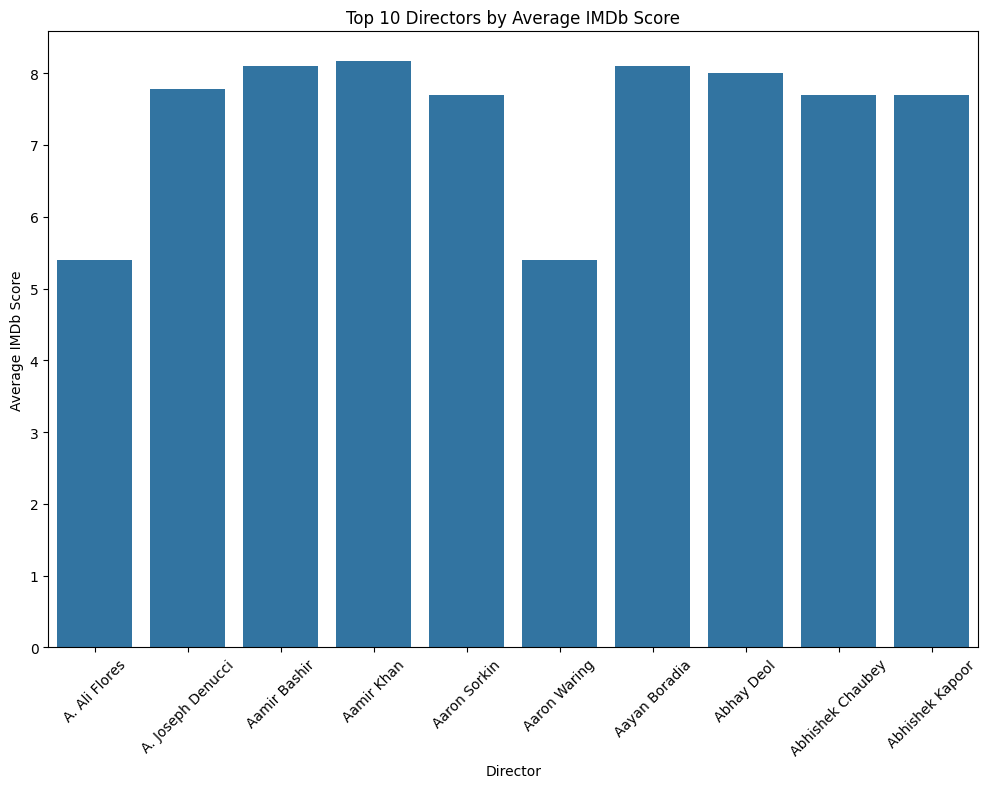

In [80]:
director_avg_imdb_scores = reremerged_df.groupby('Name')['Imdb_Score'].mean().reset_index()
plt.figure(figsize=(12, 8))
sns.barplot(x='Name', y='Imdb_Score', data=director_avg_imdb_scores.head(10))
plt.title('Top 10 Directors by Average IMDb Score')
plt.xlabel('Director')
plt.ylabel('Average IMDb Score')
plt.xticks(rotation=45)
plt.show()

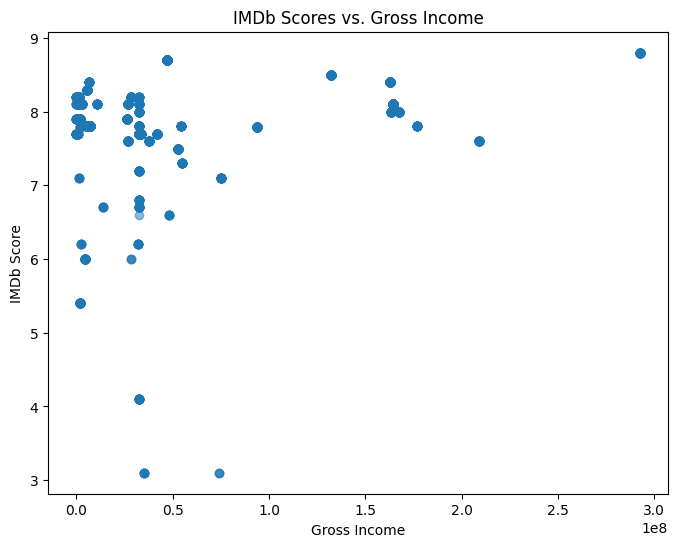

In [81]:
plt.figure(figsize=(8, 6))
plt.scatter(reremerged_df['Gross'], reremerged_df['Imdb_Score'], alpha=0.5)
plt.title('IMDb Scores vs. Gross Income')
plt.xlabel('Gross Income')
plt.ylabel('IMDb Score')
plt.show()

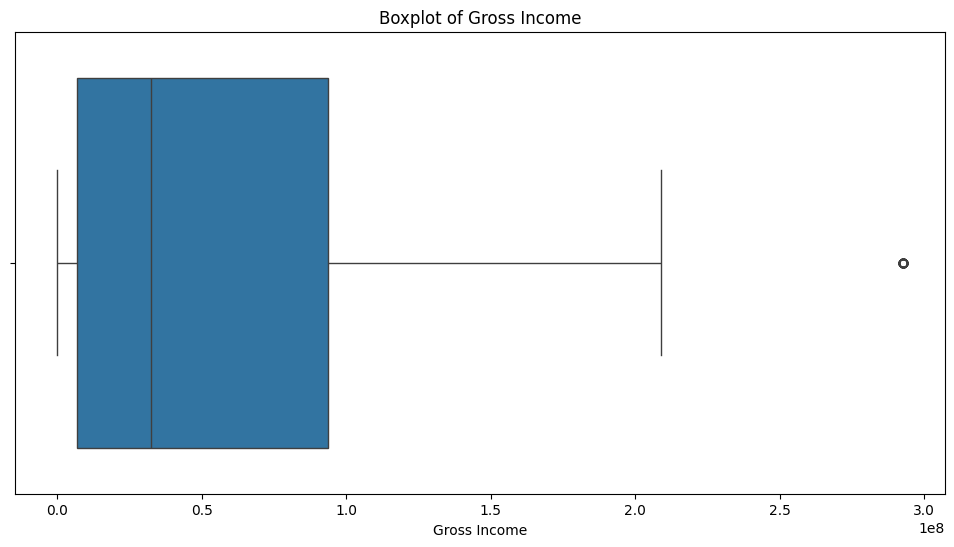

In [82]:
plt.figure(figsize=(12, 6)) #
sns.boxplot(x=reremerged_df['Gross'])
plt.title('Boxplot of Gross Income')
plt.xlabel('Gross Income')
plt.show()

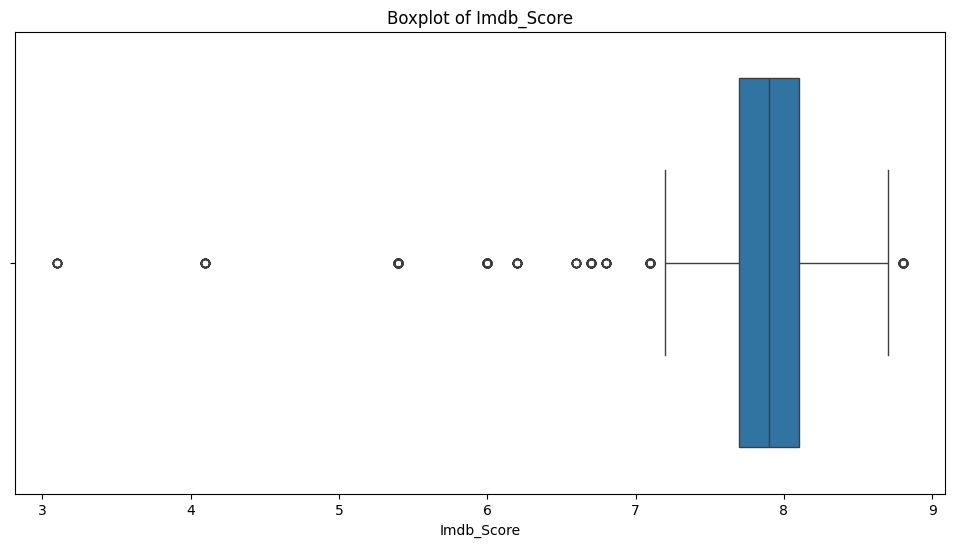

In [83]:
plt.figure(figsize=(12, 6))
sns.boxplot(x=reremerged_df['Imdb_Score'])
plt.title('Boxplot of Imdb_Score')
plt.xlabel('Imdb_Score')
plt.show()

In [84]:
from scipy import stats
z_scores = stats.zscore(reremerged_df['Imdb_Score'])

threshold = 3
outliers = np.where(np.abs(z_scores) > threshold)

print("location of all outliers:", outliers)

#replace outliers with average
reremerged_df['Imdb_Score'].loc[outliers[0]] = reremerged_df['Imdb_Score'].mean()

#outliers for gross
z_scores_gross = stats.zscore(reremerged_df['Gross'])
outliers_gross = np.where(np.abs(z_scores_gross) > threshold)
print("gross outliers location:", outliers_gross)
#filling outliers with median
median_value = reremerged_df['Gross'].median()
reremerged_df.loc[outliers_gross[0], 'Gross'] = median_value

location of all outliers: (array([1920, 1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930,
       1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941,
       1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950, 1951, 1952,
       1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961, 1962, 1963,
       1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974,
       1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985,
       1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996,
       1997, 1998, 1999, 2000, 2001, 2002, 2420, 2421, 2422, 2423, 2424,
       2425, 2426, 2435, 2436, 2437]),)
gross outliers location: (array([623, 624, 625, 626, 627, 628, 629, 630, 631, 632, 633, 634, 635,
       636, 637, 638, 639, 640, 641, 642, 643, 644, 645, 646, 647, 648,
       649, 650, 651, 652, 653, 654, 655, 656, 657, 658, 659, 660, 661,
       662, 663, 664, 665, 666, 667, 668, 669, 670]),)


<ipython-input-84-79332f76381f>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reremerged_df['Imdb_Score'].loc[outliers[0]] = reremerged_df['Imdb_Score'].mean()


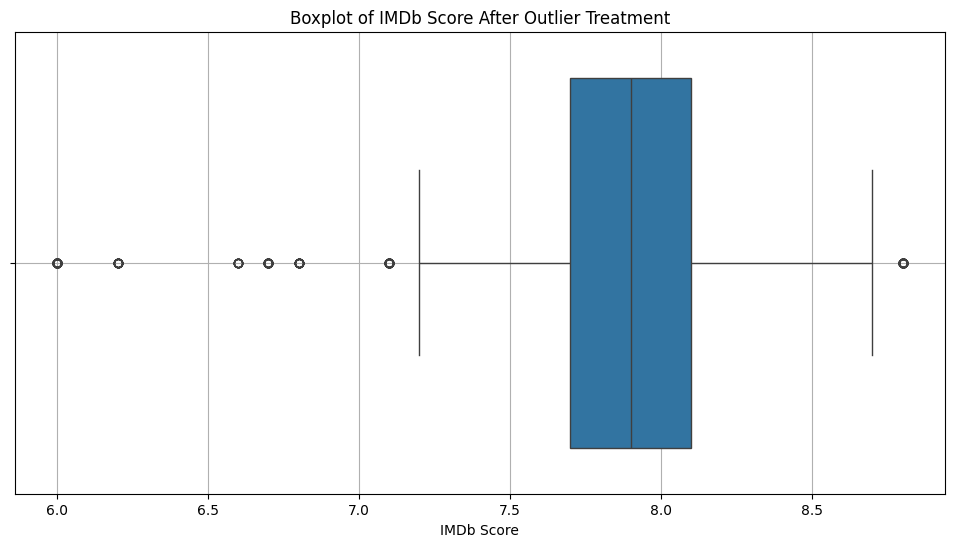

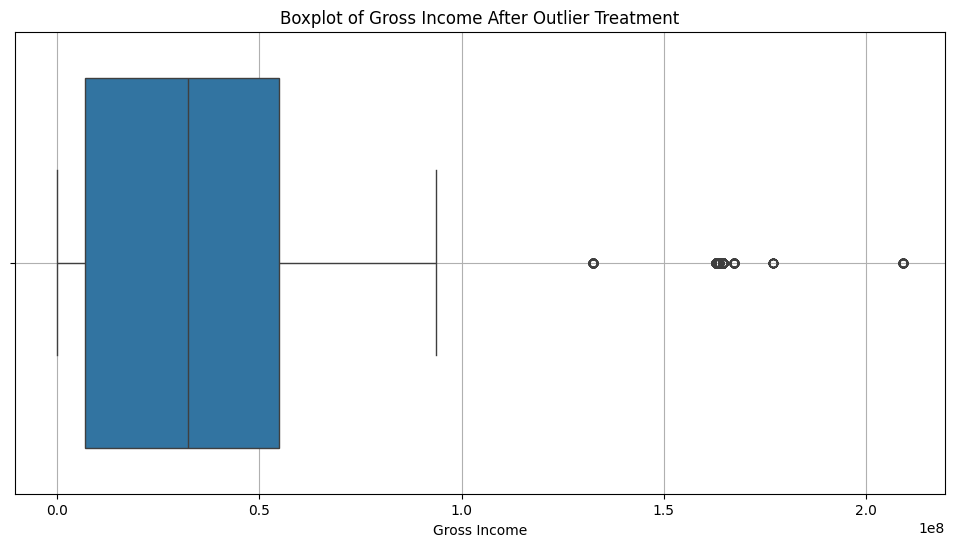

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot: Organized data for 'Imdb_Score'
plt.figure(figsize=(12, 6))
sns.boxplot(x=reremerged_df['Imdb_Score'])
plt.title('Boxplot of IMDb Score After Outlier Treatment')
plt.xlabel('IMDb Score')
plt.grid(True)
plt.show()

# Boxplot: Organized data for 'Gross'
plt.figure(figsize=(12, 6))
sns.boxplot(x=reremerged_df['Gross'])
plt.title('Boxplot of Gross Income After Outlier Treatment')
plt.xlabel('Gross Income')
plt.grid(True)
plt.show()

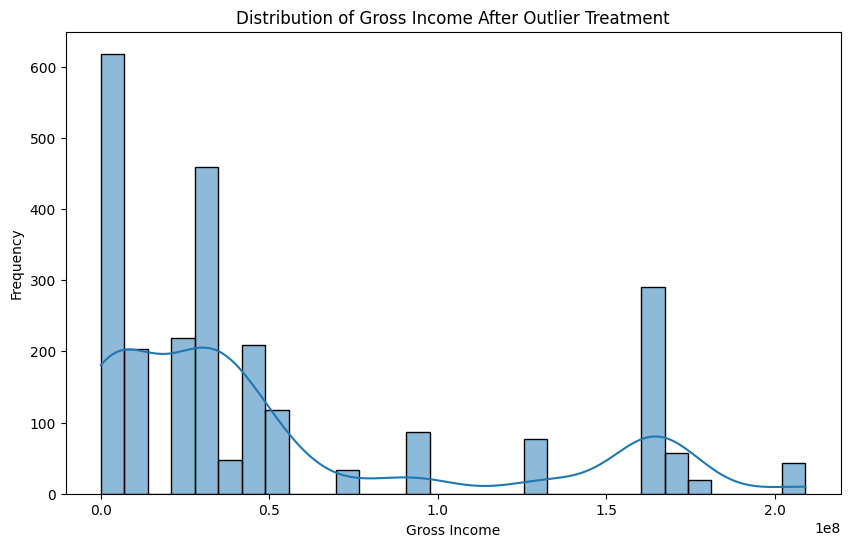

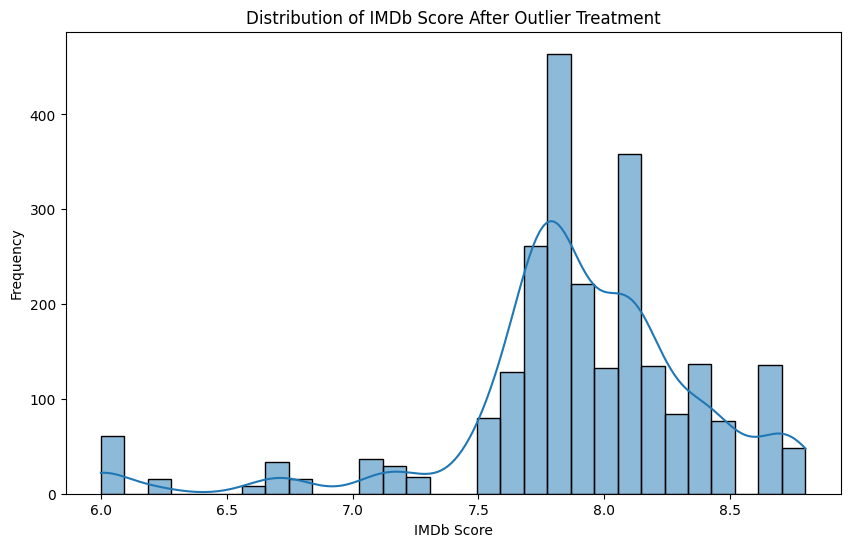

In [86]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



# Histogram: Gross Income
plt.figure(figsize=(10, 6))
sns.histplot(reremerged_df['Gross'], bins=30, kde=True)
plt.title('Distribution of Gross Income After Outlier Treatment')
plt.xlabel('Gross Income')
plt.ylabel('Frequency')
plt.show()

# Histogram: IMDb Score
plt.figure(figsize=(10, 6))
sns.histplot(reremerged_df['Imdb_Score'], bins=30, kde=True)
plt.title('Distribution of IMDb Score After Outlier Treatment')
plt.xlabel('IMDb Score')
plt.ylabel('Frequency')
plt.show()

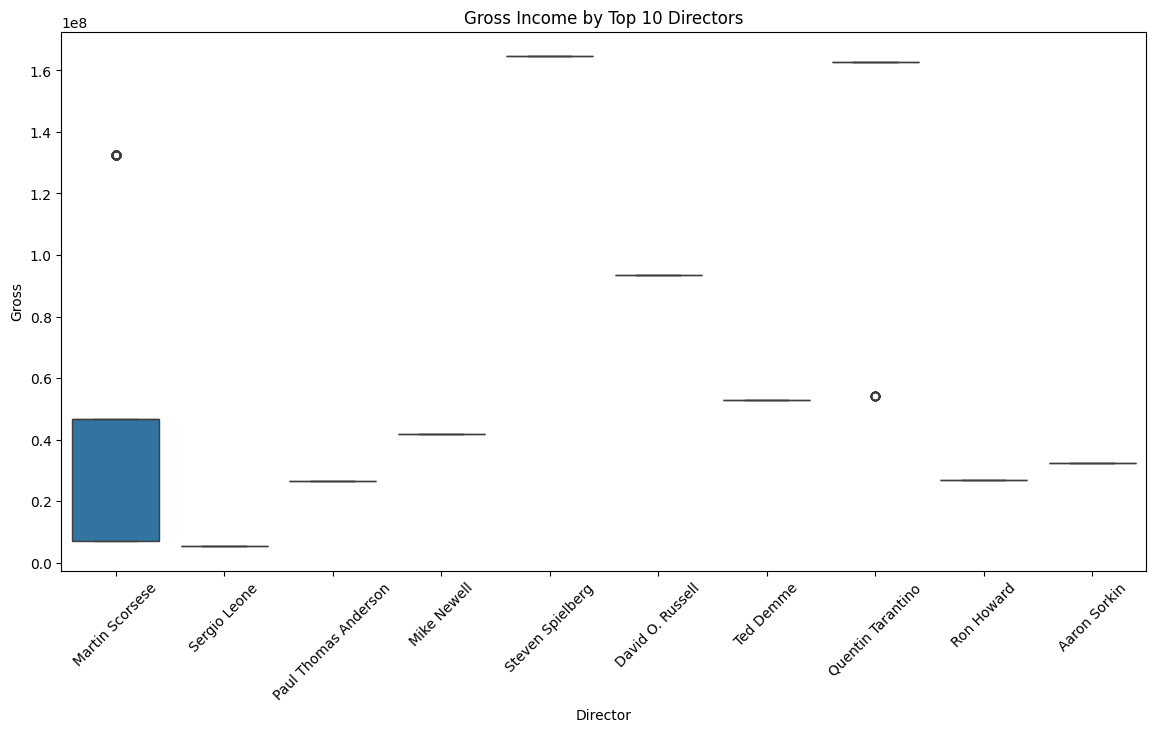

In [87]:
# Gross Income by Director
top_directors = reremerged_df['Director'].value_counts().nlargest(10).index
filtered_df = reremerged_df[reremerged_df['Director'].isin(top_directors)]

plt.figure(figsize=(14, 7))
sns.boxplot(x='Director', y='Gross', data=filtered_df)
plt.title('Gross Income by Top 10 Directors')
plt.xticks(rotation=45)
plt.show()

In [88]:

print(reremerged_df.columns)



Index(['Id', 'Title', 'Type', 'Genres', 'Imdb_Score', 'Imdb_Votes',
       'Tmdb_Popularity', 'Tmdb_Score', 'Person_Id', 'Name', 'Character',
       'Role', 'Show_Id', 'Director', 'Cast', 'Listed_In', 'Description',
       'Gross'],
      dtype='object')


In [89]:

import pandas as pd
import numpy as np


df = reremerged_df

# General statistics of important features
important_features = ['Director', 'Name', 'Genres']
print(df[important_features].describe(include=[object, np.number]))



               Director             Name              Genres
count              2479             2479                2479
unique               60             2321                  53
top     Martin Scorsese  Martin Scorsese  ['drama', 'crime']
freq                387                5                 302


In [90]:
import pandas as pd



df = reremerged_df

# Columns to remove
columns_to_remove = ['Cast', 'Listed_In']

# Remove columns
df_cleaned = df.drop(columns=columns_to_remove)



print(df_cleaned.columns)

Index(['Id', 'Title', 'Type', 'Genres', 'Imdb_Score', 'Imdb_Votes',
       'Tmdb_Popularity', 'Tmdb_Score', 'Person_Id', 'Name', 'Character',
       'Role', 'Show_Id', 'Director', 'Description', 'Gross'],
      dtype='object')


In [91]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# selecting the relevant columns
selected_columns = ['Title', 'Name', 'Role', 'Gross', 'Imdb_Score']
df_selected = df[selected_columns]

# Filtering getting only actor and director lines
df_filtered = df_selected[df_selected['Role'].isin(['ACTOR', 'DIRECTOR'])]

# getting the Gross and IMDb Score averages
df_grouped = df_filtered.groupby(['Title', 'Name', 'Role']).agg({
    'Gross': 'mean',
    'Imdb_Score': 'mean'
}).reset_index()

# Converting categorical data (One-Hot Encoding)
encoder = OneHotEncoder(sparse=False)
X = encoder.fit_transform(df_grouped[['Name', 'Role']])

#Target variables
y_gross = df_grouped['Gross']
y_imdb = df_grouped['Imdb_Score']

# Separating the data set into training and testing
X_train_gross, X_test_gross, y_train_gross, y_test_gross = train_test_split(X, y_gross, test_size=0.2, random_state=42)
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(X, y_imdb, test_size=0.2, random_state=42)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [92]:
# Ridge Regression Model creation and training
model_gross = Ridge()
model_gross.fit(X_train_gross, y_train_gross)

model_imdb = Ridge()
model_imdb.fit(X_train_imdb, y_train_imdb)


y_pred_gross = model_gross.predict(X_test_gross)
y_pred_imdb = model_imdb.predict(X_test_imdb)

# Evaluating model performance
mse_gross = mean_squared_error(y_test_gross, y_pred_gross)
mse_imdb = mean_squared_error(y_test_imdb, y_pred_imdb)

# First few lines review of Forecast Results
predicted_gross = y_pred_gross[:5]
predicted_imdb = y_pred_imdb[:5]

# model performance and prediction results
print(f'Gross Estimated MSE: {mse_gross}')
print(f'IMDb Skoru Tahmini MSE: {mse_imdb}')
print("Estimated Gross values:", predicted_gross)
print("Predicted IMDb Score values:", predicted_imdb)


Gross Estimated MSE: 3521401035152586.0
IMDb Skoru Tahmini MSE: 0.29543949555022075
Estimated Gross values: [53780920.94845701 53780920.94845701 53780920.94845701 27341265.47422852
 53780920.94845701]
Predicted IMDb Score values: [7.88571724 7.88571724 7.88571724 7.99285862 7.88571724]


In [93]:

# Hiperparametre grid
param_grid = {'alpha': [0.01, 0.1, 1, 10, 100]}

# Gross için Grid Search
grid_search_gross = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_gross.fit(X_train_gross, y_train_gross)

# En iyi parametreleri al
best_alpha_gross = grid_search_gross.best_params_['alpha']
print(f'Gross modeli için en iyi alpha: {best_alpha_gross}')

# Gross modelini en iyi parametrelerle eğit
model_gross = Ridge(alpha=best_alpha_gross)
model_gross.fit(X_train_gross, y_train_gross)
y_pred_gross = model_gross.predict(X_test_gross)
mse_gross = mean_squared_error(y_test_gross, y_pred_gross)
print(f'Gross Estimated MSE: {mse_gross}')

# IMDb için Grid Search
grid_search_imdb = GridSearchCV(Ridge(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search_imdb.fit(X_train_imdb, y_train_imdb)

# En iyi parametreleri al
best_alpha_imdb = grid_search_imdb.best_params_['alpha']
print(f'IMDb modeli için en iyi alpha: {best_alpha_imdb}')

# IMDb modelini en iyi parametrelerle eğit
model_imdb = Ridge(alpha=best_alpha_imdb)
model_imdb.fit(X_train_imdb, y_train_imdb)
y_pred_imdb = model_imdb.predict(X_test_imdb)
mse_imdb = mean_squared_error(y_test_imdb, y_pred_imdb)
print(f'IMDb Skoru Tahmini MSE: {mse_imdb}')


Gross modeli için en iyi alpha: 10
Gross Estimated MSE: 3567758694301621.0
IMDb modeli için en iyi alpha: 10
IMDb Skoru Tahmini MSE: 0.2947524400994122


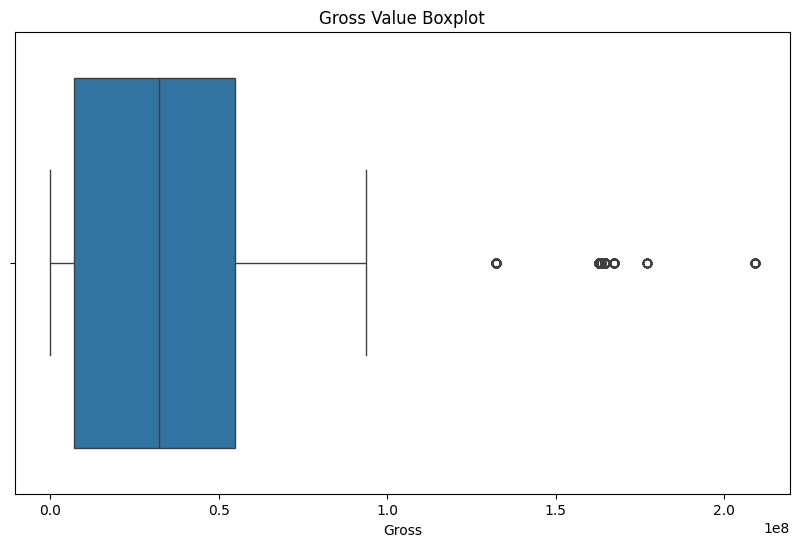

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(x=df_grouped['Gross'])
plt.title('Gross Value Boxplot')
plt.show()


In [95]:
# Aşırı değerleri tespit etmek
Q1 = df_grouped['Gross'].quantile(0.25)
Q3 = df_grouped['Gross'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_grouped[(df_grouped['Gross'] < lower_bound) | (df_grouped['Gross'] > upper_bound)]
print("Aşırı Değerler:\n", outliers)


Aşırı Değerler:
                          Title                  Name   Role        Gross  \
309              casino royale                   Ade  ACTOR  167445960.0   
310              casino royale   Alessandra Ambrosio  ACTOR  167445960.0   
311              casino royale    Alexander Hathaway  ACTOR  167445960.0   
312              casino royale        Andreas Daniel  ACTOR  167445960.0   
313              casino royale             Ben Cooke  ACTOR  167445960.0   
...                        ...                   ...    ...          ...   
2267  the pursuit of happyness  Victor Raider-Wexler  ACTOR  163566459.0   
2268  the pursuit of happyness            Will Smith  ACTOR  163566459.0   
2269  the pursuit of happyness          Yeena Fisher  ACTOR  163566459.0   
2270  the pursuit of happyness    Zachary Culbertson  ACTOR  163566459.0   
2271  the pursuit of happyness         Zuhair Haddad  ACTOR  163566459.0   

      Imdb_Score  
309          8.0  
310          8.0  
311          

In [96]:
df_grouped['Gross_log'] = np.log1p(df_grouped['Gross'])

In [97]:
import numpy as np

# Detecting outliers
Q1 = df_grouped['Gross'].quantile(0.25)
Q3 = df_grouped['Gross'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Removing outliers ​​from the data set
df_no_outliers = df_grouped[(df_grouped['Gross'] >= lower_bound) & (df_grouped['Gross'] <= upper_bound)]
print(f"Data without outliers:\n{df_no_outliers.head()}")


Data without outliers:
      Title           Name   Role      Gross  Imdb_Score  Gross_log
0  3 idiots     Aamir Khan  ACTOR  6532908.0         8.4  15.692363
1  3 idiots  Achyut Potdar  ACTOR  6532908.0         8.4  15.692363
2  3 idiots   Akhil Mishra  ACTOR  6532908.0         8.4  15.692363
3  3 idiots      Ali Fazal  ACTOR  6532908.0         8.4  15.692363
4  3 idiots   Amardeep Jha  ACTOR  6532908.0         8.4  15.692363


In [98]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# One-Hot Encoding and data separation again
encoder = OneHotEncoder(sparse=False)
X = encoder.fit_transform(df_no_outliers[['Name', 'Role']])
y_gross = df_no_outliers['Gross']

X_train_gross, X_test_gross, y_train_gross, y_test_gross = train_test_split(X, y_gross, test_size=0.2, random_state=42)

# Model training
best_alpha_gross = 10  # Daha önce GridSearchCV ile bulunan en iyi alpha değerini kullanın
model_gross = Ridge(alpha=best_alpha_gross)
model_gross.fit(X_train_gross, y_train_gross)
y_pred_gross = model_gross.predict(X_test_gross)
mse_gross = mean_squared_error(y_test_gross, y_pred_gross)
print(f'Gross Estimated MSE (No Outliers): {mse_gross}')


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Gross Estimated MSE (No Outliers): 542681839685671.7


In [125]:
import numpy as np

# Logarithmic transformation is used to reduce the effect of large values
df_no_outliers['Gross_log'] = np.log1p(df_no_outliers['Gross'])

# Logarithmically transformed Gross value
y_gross_log = df_no_outliers['Gross_log']

# One-Hot Encoding and data separation
X = encoder.fit_transform(df_no_outliers[['Name', 'Role']])
X_train_gross, X_test_gross, y_train_gross, y_test_gross = train_test_split(X, y_gross_log, test_size=0.2, random_state=42)

# Model training
model_gross = Ridge(alpha=best_alpha_gross)
model_gross.fit(X_train_gross, y_train_gross)
y_pred_gross = model_gross.predict(X_test_gross)

# MSE calculation and inversion of logarithmic values
mse_gross_log = mean_squared_error(np.expm1(y_test_gross), np.expm1(y_pred_gross))
print(f'Gross Estimated MSE (Log Transformed, No Outliers): {mse_gross_log}')


<ipython-input-125-689dc33cfa4e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Gross_log'] = np.log1p(df_no_outliers['Gross'])


Gross Estimated MSE (Log Transformed, No Outliers): 769018504374621.1


In [100]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error


df =reremerged_df

# selecting the relevant columns and filter the dataset
df_selected = df[['Title', 'Name', 'Role', 'Gross', 'Imdb_Score']]


df_filtered = df_selected[df_selected['Role'].isin(['ACTOR', 'DIRECTOR'])]

# Logarithmic conversion (for Gross values)
df_filtered['Log_Gross'] = np.log1p(df_filtered['Gross'])

# Converting categorical data (One-Hot Encoding)
encoder = OneHotEncoder(sparse_output=False)
X = encoder.fit_transform(df_filtered[['Name', 'Role']])

# Target variables
y_gross = df_filtered['Log_Gross']
y_imdb = df_filtered['Imdb_Score']

# Separating the data set into training and testing
X_train_gross, X_test_gross, y_train_gross, y_test_gross = train_test_split(X, y_gross, test_size=0.2, random_state=42)
X_train_imdb, X_test_imdb, y_train_imdb, y_test_imdb = train_test_split(X, y_imdb, test_size=0.2, random_state=42)

# Hyperparameter Optimization for Ridge Regression Model
param_grid = {'alpha': [0.1, 1.0, 10.0, 100.0]}
ridge_gross = Ridge()
ridge_imdb = Ridge()


cv_folds = min(3, len(X_train_gross))

grid_search_gross = GridSearchCV(ridge_gross, param_grid, cv=cv_folds, scoring='neg_mean_squared_error')
grid_search_gross.fit(X_train_gross, y_train_gross)

grid_search_imdb = GridSearchCV(ridge_imdb, param_grid, cv=cv_folds, scoring='neg_mean_squared_error')
grid_search_imdb.fit(X_train_imdb, y_train_imdb)

best_model_gross = grid_search_gross.best_estimator_
best_model_imdb = grid_search_imdb.best_estimator_

# Make predictions and evaluate performance
y_pred_gross = best_model_gross.predict(X_test_gross)
y_pred_imdb = best_model_imdb.predict(X_test_imdb)

# Calculating MSE by undoing log transformation
mse_gross = mean_squared_error(np.expm1(y_test_gross), np.expm1(y_pred_gross))
mse_imdb = mean_squared_error(y_test_imdb, y_pred_imdb)

# Review the first few predictions
predicted_gross = np.expm1(y_pred_gross[:5])  # Log dönüşümünü geri alarak tahminleri incele
predicted_imdb = y_pred_imdb[:5]

print(f'Optimized Gross Estimated MSE: {mse_gross}')
print(f'Optimized IMDb Skoru Tahmini MSE: {mse_imdb}')
print("Estimated Gross values:", predicted_gross)
print("Predicted IMDb Score values:", predicted_imdb)


Optimized Gross Estimated MSE: 4571508734849378.0
Optimized IMDb Skoru Tahmini MSE: 0.24677719414475632
Estimated Gross values: [20860159.69188032 20860159.69188032 20860159.69188032 20860159.69188032
 20860159.69188032]
Predicted IMDb Score values: [7.8909682 7.8909682 7.8909682 7.8909682 7.8909682]


In [101]:
from sklearn.ensemble import GradientBoostingRegressor

model_gross_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_gross_gb.fit(X_train_gross, y_train_gross)
y_pred_gross_gb = model_gross_gb.predict(X_test_gross)

mse_gross_gb = mean_squared_error(y_test_gross, y_pred_gross_gb)
print(f'Gross Estimated MSE (Gradient Boosting): {mse_gross_gb}')


Gross Estimated MSE (Gradient Boosting): 3.6840357511128596


In [59]:
# Gradient Boosting Model for Gross
model_gross_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_gross_gb.fit(X_train_gross, y_train_gross)
y_pred_gross_gb = model_gross_gb.predict(X_test_gross)

mse_gross_gb = mean_squared_error(y_test_gross, y_pred_gross_gb)
print(f'Gross Estimated MSE (Gradient Boosting): {mse_gross_gb}')

# Gradient Boosting Model for IMDb
model_imdb_gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
model_imdb_gb.fit(X_train_imdb, y_train_imdb)
y_pred_imdb_gb = model_imdb_gb.predict(X_test_imdb)

mse_imdb_gb = mean_squared_error(y_test_imdb, y_pred_imdb_gb)
print(f'IMDb Estimated MSE (Gradient Boosting): {mse_imdb_gb}')


Gross Estimated MSE (Gradient Boosting): 2.5602030697202482
IMDb Estimated MSE (Gradient Boosting): 0.24647663649910959


In [105]:
print(df_filtered.columns)


Index(['Title', 'Name', 'Role', 'Gross', 'Imdb_Score', 'Log_Gross'], dtype='object')


In [107]:
# Checking and removing Gross values ​​that are negative or zero
df_filtered = df_filtered[df_filtered['Gross'] > 0]


df_filtered['Log_Gross'] = np.log1p(df_filtered['Gross'])


In [109]:
from sklearn.linear_model import LinearRegression

# Linear Regression for Gross
model_gross_lr = LinearRegression()
model_gross_lr.fit(X_train_gross, y_train_gross)
y_pred_gross_lr = model_gross_lr.predict(X_test_gross)

# Linear Regression for IMDb Score
model_imdb_lr = LinearRegression()
model_imdb_lr.fit(X_train_imdb, y_train_imdb)
y_pred_imdb_lr = model_imdb_lr.predict(X_test_imdb)

# MSE calculation
mse_gross_lr = mean_squared_error(y_test_gross, y_pred_gross_lr)
mse_imdb_lr = mean_squared_error(y_test_imdb, y_pred_imdb_lr)

print(f'Linear Regression Gross MSE: {mse_gross_lr}')
print(f'Linear Regression IMDb MSE: {mse_imdb_lr}')


Linear Regression Gross MSE: 3.2761399697488236e+27
Linear Regression IMDb MSE: 3.910939522048912e+26


In [110]:
#Checking and removing Gross values ​​that are negative or zero
df_filtered = df_filtered[df_filtered['Gross'] > 0]


df_filtered['Log_Gross'] = np.log1p(df_filtered['Gross'])


In [115]:
from sklearn.svm import SVR

# SVR for Gross
model_gross_svr = SVR(kernel='linear')
model_gross_svr.fit(X_train_gross, y_train_gross)
y_pred_gross_svr = model_gross_svr.predict(X_test_gross)
mse_gross_svr = mean_squared_error(np.expm1(y_test_gross), np.expm1(y_pred_gross_svr))

# SVR for IMDb Score
model_imdb_svr = SVR(kernel='linear')
model_imdb_svr.fit(X_train_imdb, y_train_imdb)
y_pred_imdb_svr = model_imdb_svr.predict(X_test_imdb)
mse_imdb_svr = mean_squared_error(y_test_imdb, y_pred_imdb_svr)

print(f'SVR Gross MSE: {mse_gross_svr}')
print(f'SVR IMDb MSE: {mse_imdb_svr}')

SVR Gross MSE: 4195222358004915.5
SVR IMDb MSE: 0.25133361815770866
